# Analyze Embedding Vectors  

In this notebook, we will analyze the embedding vectors. Those vectors were obtained from a classifier trained to recognize MoA. We will therefore have a look at how scattered the embedding vectors are if we group them per compound. If the vectors for a given compound are highly similar to each other, this will be an indication that the embeddings generated to recognize a MoA also contain information on the compound itself.

In [99]:
import os

import pandas as pd
import numpy as np

from scipy.spatial import distance

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.lines import Line2D

from sklearn.manifold import TSNE

import umap

In [100]:
embed_path = "../data/embeddings"
image_dir = "../images"

## Load Dataset  
Load the BBBC021 original dataset incl. the embedding vectors created with one of the following pre-trained models  
* Inception V3 base model
* Inception V3 fine-tuned on the last 2 convolutional mixture layers
* Inception V3 last 2 layers finetuning + data augmentation (flip vertical and horizontal, random roation 90 degrees)
* DinoV2 vision transformer ViT-S/14

In [101]:
df = pd.read_csv(os.path.join(embed_path, "embeddings_l2l_MoA_only_8bit_bc.csv"))
df = df.drop(columns=["Unnamed: 0"])  # need to be removed, artifact of merging (should be fixed there)

In [102]:
df.head()

,TableNumber,ImageNumber,Image_FileName_DAPI,Image_PathName_DAPI,Image_FileName_Tubulin,Image_PathName_Tubulin,Image_FileName_Actin,Image_PathName_Actin,Image_Metadata_Plate_DAPI,Image_Metadata_Well_DAPI,...,V2038,V2039,V2040,V2041,V2042,V2043,V2044,V2045,V2046,V2047
0,2,113,Week2_180607_D10_s1_w13459A84F-B9BB-4FB2-B58E-...,Week2/Week2_24121,Week2_180607_D10_s1_w2D35FB8FC-0085-4F4D-B14A-...,Week2/Week2_24121,Week2_180607_D10_s1_w440EA0925-FF71-447F-B395-...,Week2/Week2_24121,Week2_24121,D10,...,0.598801,0.165157,0.349580,0.240558,0.232831,0.190724,0.216562,0.466217,0.217871,0.476633
1,2,114,Week2_180607_D10_s2_w111F1FA1E-8B45-451D-9C50-...,Week2/Week2_24121,Week2_180607_D10_s2_w277BE8611-E2E6-456E-838C-...,Week2/Week2_24121,Week2_180607_D10_s2_w433B4BF8D-9087-401F-89B1-...,Week2/Week2_24121,Week2_24121,D10,...,0.774047,0.220835,0.647705,0.225403,0.237141,0.195058,0.157998,0.440013,0.349144,0.429633
2,2,115,Week2_180607_D10_s3_w13C4CF98E-5824-43A6-A319-...,Week2/Week2_24121,Week2_180607_D10_s3_w2D8C8A48C-6EAF-463F-A673-...,Week2/Week2_24121,Week2_180607_D10_s3_w4E03CCDE6-86D5-4F10-9B54-...,Week2/Week2_24121,Week2_24121,D10,...,0.537046,0.446406,0.603448,0.473396,0.434939,0.248369,0.138446,0.370426,0.472364,0.404236
3,2,116,Week2_180607_D10_s4_w1E4144E18-06FF-4789-8F9F-...,Week2/Week2_24121,Week2_180607_D10_s4_w25BD84D0B-672D-4292-87B7-...,Week2/Week2_24121,Week2_180607_D10_s4_w4A0FA5EEA-D0F6-4857-9C81-...,Week2/Week2_24121,Week2_24121,D10,...,1.065903,0.259793,0.182259,0.379818,0.290877,0.238712,0.317723,0.432714,0.536339,0.550825
4,2,353,Week2_180607_D10_s1_w199106068-CEA7-4BAB-83EA-...,Week2/Week2_24141,Week2_180607_D10_s1_w20787BC73-DFAE-40D7-80BA-...,Week2/Week2_24141,Week2_180607_D10_s1_w4E09AB7C1-BAF1-4FFE-BFC7-...,Week2/Week2_24141,Week2_24141,D10,...,0.584237,0.267403,0.693121,0.609006,0.171457,0.222612,0.192032,0.727877,0.513483,0.376689


Get embedding vector columns.

In [103]:
vec_cols = [c for c in df.columns if c[0] == "V"]

## Embedding Vectors By Compound  
Let's now calculate the mean vector per compound, and the cosine similarity of each individual embedding vectors with this mean vector. This will provide us with a metrics to estimate how scattered the embedding vectors are for each compound.
We will also create a dataframe containing, for each compound, the percentage of vectors that have a cosine similarity with the mean vector superior to 90%.

In [104]:
# Function to remove outliers based on the IQR rule
def remove_outliers(df):
    q1 = df["distance_to_mean_vec"].quantile(0.25)
    q3 = df["distance_to_mean_vec"].quantile(0.75)
    iqr = q3 - q1
    df = df[~((df["distance_to_mean_vec"] < (q1 - 1.5 * iqr)) | (df["distance_to_mean_vec"] > (q3 + 1.5 * iqr)))]

    return df

### Visualize Embedding Vectors Without Outlier Removal

In [105]:
# create new dataframe without outlier removal
df_corrected = pd.DataFrame()

compound_dist_histos = dict()
compound_vec_stats = list()
compound_vec_dists = list()
for compound in df["Image_Metadata_Compound"].unique():
    df_compound = df[df["Image_Metadata_Compound"] == compound].copy()
    compound_moa = df_compound["Image_Metadata_MoA"].unique()[0]

    df_mean_vec = (
        df_compound.groupby(["Image_Metadata_Compound"])[vec_cols].mean().reset_index()
    )
    df_compound_data = df_compound[vec_cols].to_numpy()
    df_compound_mean = df_mean_vec[vec_cols].to_numpy()

    num_tot_vectors = df_compound.shape[0]

    # get mean vector of the compound
    df_compound["distance_to_mean_vec"] = df_compound.apply(lambda r: distance.cosine(df_compound_mean[0], r[vec_cols]), axis=1)
    
    # outlier remval using the IQR rule
    # df_compound = remove_outliers(df_compound)

    df_corrected = pd.concat([df_corrected, df_compound], axis=0)
    
    num_corr_vectors = df_compound.shape[0]

    num_vectors_min_90 = np.extract(df_compound["distance_to_mean_vec"] < 0.1, df_compound["distance_to_mean_vec"]).shape[0]

    compound_vec_stats.append(
        (
            compound,
            num_tot_vectors,
            num_corr_vectors,
            num_vectors_min_90,
            (num_vectors_min_90 / num_corr_vectors) * 100,
        )
    )

    compound_histo = np.histogram(df_compound["distance_to_mean_vec"])
    compound_dist_histos[compound] = compound_histo
    compound_vec_dists.extend(list(zip([compound]*len(df_compound["distance_to_mean_vec"]), 
                                       df_compound["distance_to_mean_vec"].to_list(), 
                                       [compound_moa]*len(df_compound["distance_to_mean_vec"]))))

df_compound_vec_dists = pd.DataFrame().from_records(
    data=compound_vec_dists, 
    columns=["compound", "distance", "moa"]
)
df_compound_vec_dists = df_compound_vec_dists.sort_values(by=["moa", "compound"])

df_compound_vec_stats = pd.DataFrame.from_records(
    data=compound_vec_stats,
    columns=["compound", "total no vectors", "corrected no vectors", "corrected no vectors > 0.9", "percentage vectors > 0.9"],
)
df_compound_vec_stats.shape

(39, 5)

In [106]:
df_compound_vec_stats.head()

,compound,total no vectors,corrected no vectors,corrected no vectors > 0.9,percentage vectors > 0.9
0,ALLN,96,96,94,97.916667
1,alsterpaullone,64,64,57,89.062500
2,anisomycin,96,96,16,16.666667
3,bryostatin,64,64,47,73.437500
4,camptothecin,96,96,79,82.291667


Let's now visualize the results. We will first plot the box plots, to visualize the distribution of the cosine distances with respect to the mean vector, for each compound. We will color the box plots per MoA.

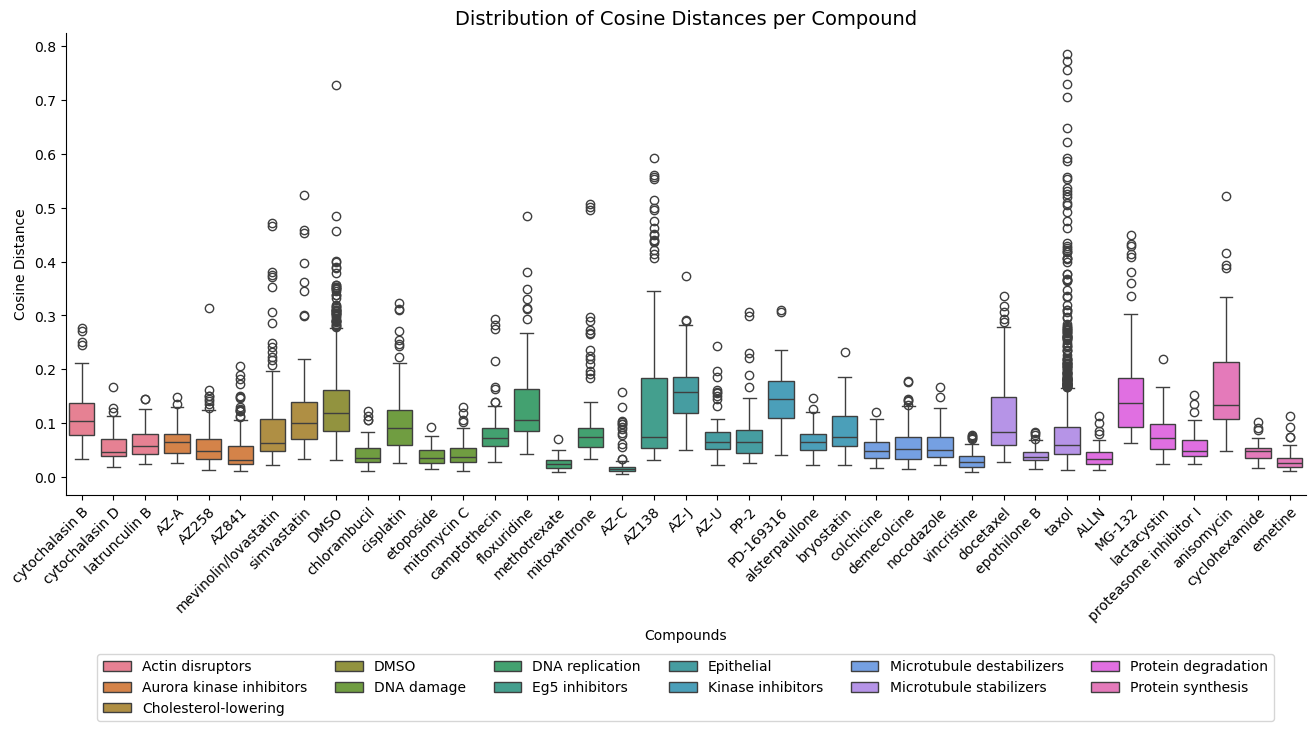

In [107]:
fig, ax = plt.subplots(figsize=(16, 6))

sns.boxplot(data=df_compound_vec_dists, x="compound", y="distance", hue="moa", ax=ax)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel("Compounds")
ax.set_ylabel("Cosine Distance")
ax.set_title("Distribution of Cosine Distances per Compound", fontsize=14)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.33), fancybox=True, shadow=False, ncol=6)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

plt.show()

In [108]:
fig.savefig(os.path.join(image_dir, "Cosine_distance_embd_vecs_compound_boxplot.png"), bbox_inches="tight")

It looks like most distributions are heavily skewed to the left. For most compounds, the median is below 0.1, meaning for most compounds, at least half of the embedding vectors are verw similar to the mean vector. This indicates that if we group per compound, we tend to get similar embedding vectors, and therefore, that the embeddings generated based on the MoA seem to be highly similar with each other if we group per compound. This would tend to indicate that the embedding vectors generated only based on MoA also contain information on the compound itself. There however seems to be a large number of outliers in the distributions.

Let's now visualize the percentage of vecotrs for each compound, that have a percentage of similarity with the mean vector superior to 90%.

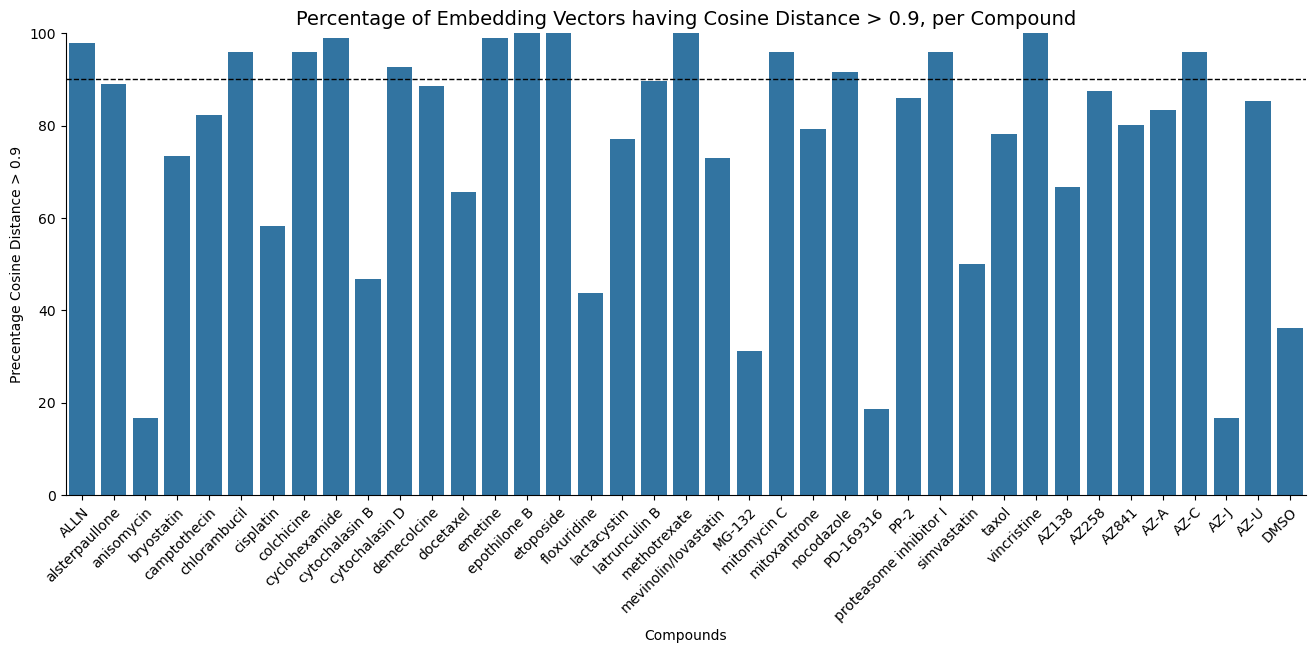

In [109]:
fig, ax = plt.subplots(figsize=(16, 6))

sns.barplot(data=df_compound_vec_stats, x="compound", y="percentage vectors > 0.9", ax=ax)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel("Compounds")
ax.set_ylabel("Precentage Cosine Distance > 0.9")
ax.set_title("Percentage of Embedding Vectors having Cosine Distance > 0.9, per Compound", fontsize=14)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
plt.ylim(0, 100)
plt.axhline(y=90, linewidth=1, linestyle="--", color="black")

plt.show()

In [110]:
fig.savefig(os.path.join(image_dir, "Embd_vecs_compound_gt90_barplot.png"), bbox_inches="tight")

### Visualize Embedding Vectors With Outlier Removal  

The visualizations above based on all image embeddings show that there are a large number of outliers. We now apply outlier detection and removal using the simple but robust IQR rule because the distributions are heavily skewed.

In [111]:
# create new dataframe with outlier removal
df_corrected = pd.DataFrame()

compound_dist_histos = dict()
compound_vec_stats = list()
compound_vec_dists = list()
for compound in df["Image_Metadata_Compound"].unique():
    df_compound = df[df["Image_Metadata_Compound"] == compound].copy()
    compound_moa = df_compound["Image_Metadata_MoA"].unique()[0]

    df_mean_vec = (
        df_compound.groupby(["Image_Metadata_Compound"])[vec_cols].mean().reset_index()
    )
    df_compound_data = df_compound[vec_cols].to_numpy()
    df_compound_mean = df_mean_vec[vec_cols].to_numpy()

    num_tot_vectors = df_compound.shape[0]

    # get mean vector of the compound
    df_compound["distance_to_mean_vec"] = df_compound.apply(lambda r: distance.cosine(df_compound_mean[0], r[vec_cols]), axis=1)
    
    # outlier remval using the IQR rule
    df_compound = remove_outliers(df_compound)

    df_corrected = pd.concat([df_corrected, df_compound], axis=0)
    
    num_corr_vectors = df_compound.shape[0]

    num_vectors_min_90 = np.extract(df_compound["distance_to_mean_vec"] < 0.1, df_compound["distance_to_mean_vec"]).shape[0]

    compound_vec_stats.append(
        (
            compound,
            num_tot_vectors,
            num_corr_vectors,
            num_vectors_min_90,
            (num_vectors_min_90 / num_corr_vectors) * 100,
        )
    )

    compound_histo = np.histogram(df_compound["distance_to_mean_vec"])
    compound_dist_histos[compound] = compound_histo
    compound_vec_dists.extend(list(zip([compound]*len(df_compound["distance_to_mean_vec"]), 
                                       df_compound["distance_to_mean_vec"].to_list(), 
                                       [compound_moa]*len(df_compound["distance_to_mean_vec"]))))

df_compound_vec_dists = pd.DataFrame().from_records(
    data=compound_vec_dists, 
    columns=["compound", "distance", "moa"]
)
df_compound_vec_dists = df_compound_vec_dists.sort_values(by=["moa", "compound"])

df_compound_vec_stats = pd.DataFrame.from_records(
    data=compound_vec_stats,
    columns=["compound", "total no vectors", "corrected no vectors", "corrected no vectors > 0.9", "percentage vectors > 0.9"],
)
df_compound_vec_stats.shape

(39, 5)

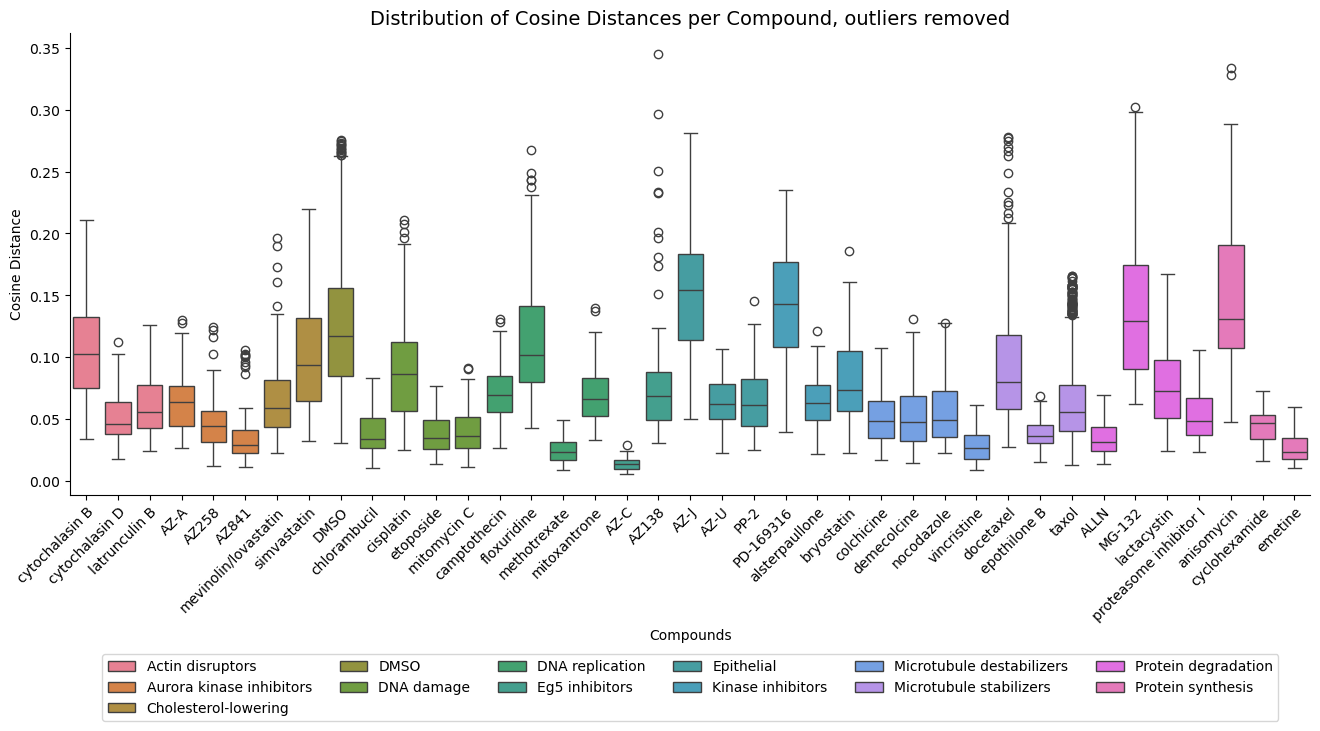

In [112]:
fig, ax = plt.subplots(figsize=(16, 6))

sns.boxplot(data=df_compound_vec_dists, x="compound", y="distance", hue="moa", ax=ax)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel("Compounds")
ax.set_ylabel("Cosine Distance")
ax.set_title("Distribution of Cosine Distances per Compound, outliers removed", fontsize=14)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.33), fancybox=True, shadow=False, ncol=6)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

plt.show()

In [113]:
fig.savefig(os.path.join(image_dir, "Cosine_distance_embd_vecs_compound_boxplot_no_outliers.png"), bbox_inches="tight")

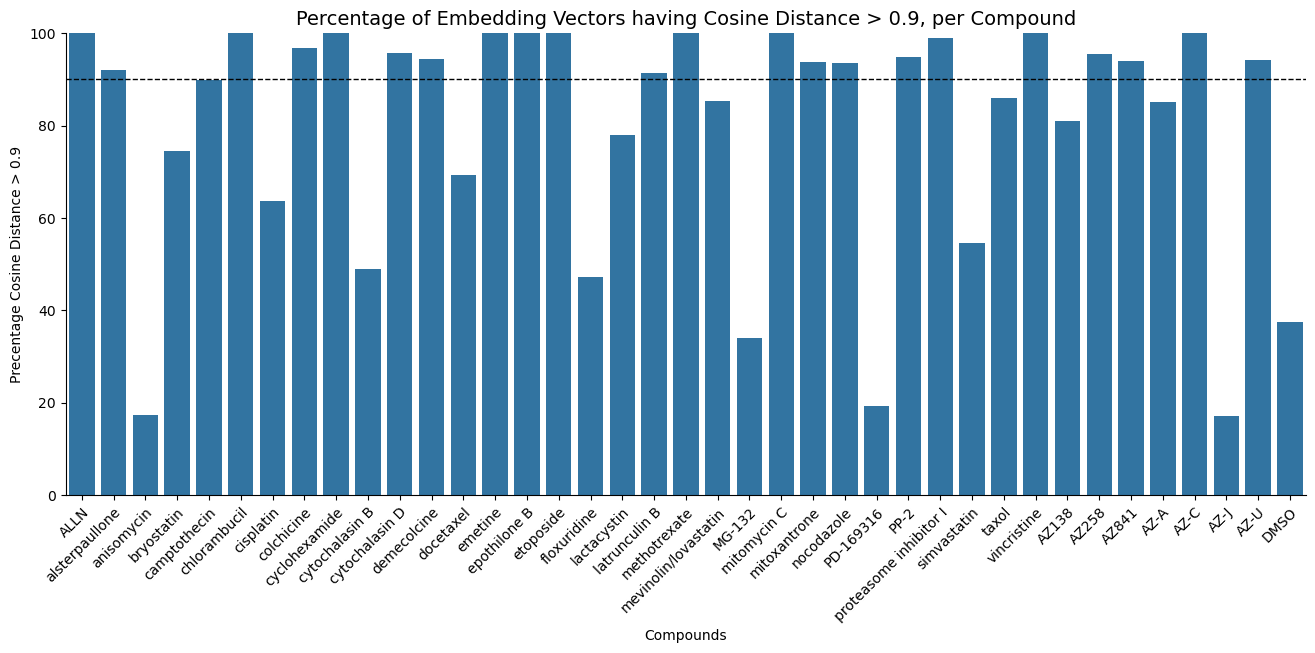

In [114]:
fig, ax = plt.subplots(figsize=(16, 6))

sns.barplot(data=df_compound_vec_stats, x="compound", y="percentage vectors > 0.9", ax=ax)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel("Compounds")
ax.set_ylabel("Precentage Cosine Distance > 0.9")
ax.set_title("Percentage of Embedding Vectors having Cosine Distance > 0.9, per Compound", fontsize=14)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
plt.ylim(0, 100)
plt.axhline(y=90, linewidth=1, linestyle="--", color="black")

plt.show()

In [115]:
fig.savefig(os.path.join(image_dir, "Embd_vecs_compound_gt90_barplot_no_outliers.png"), bbox_inches="tight")

By applying outlier detection and removal using the IQR rule results get better, even though the overall pattern largely stays at is.

## Embedding Vectors By MoA  
In addition to analyzing the embedding vectors by compound we also wanted to see how the distributions will look like if we group by MoA. Like with compounds we will also use the Cosine distance between the vectors. In addition we will visualize with and without outlier removal because we are expeting to see similar outlier patterns.

In [116]:
df["Image_Metadata_MoA"].unique()

array(['Protein degradation', 'Kinase inhibitors', 'Protein synthesis',
       'DNA replication', 'DNA damage', 'Microtubule destabilizers',
       'Actin disruptors', 'Microtubule stabilizers',
       'Cholesterol-lowering', 'Epithelial', 'Eg5 inhibitors',
       'Aurora kinase inhibitors', 'DMSO'], dtype=object)

In [117]:
df[df["Image_Metadata_MoA"] == "Protein degradation"].shape

(384, 2062)

### Visualize Embedding Vectors Without Outlier Removal

In [118]:
moa_dist_histos = dict()
moa_vec_stats = list()
moa_vec_dists = list()
for moa in df["Image_Metadata_MoA"].unique():
    df_moa = df[df["Image_Metadata_MoA"] == moa].copy()

    df_mean_vec = (
        df_moa.groupby(["Image_Metadata_MoA"])[vec_cols].mean().reset_index()
    )
    df_moa_data = df_moa[vec_cols].to_numpy()
    df_moa_mean = df_mean_vec[vec_cols].to_numpy()

    num_tot_vectors = df_moa.shape[0]

    # outlier remval using the IQR rule
    df_moa["distance_to_mean_vec"] = df_moa.apply(lambda r: distance.cosine(df_moa_mean[0], r[vec_cols]), axis=1)

    num_corr_vectors = df_moa.shape[0]
    
    moa_dist = np.zeros((df_moa_data.shape[0]))
    for i in range(df_moa_data.shape[0]):
        moa_dist[i] = distance.cosine(df_moa_mean[0], df_moa_data[i, :])

    num_vectors_min_90 = np.extract(df_moa["distance_to_mean_vec"] < 0.1, df_moa["distance_to_mean_vec"]).shape[0]

    moa_vec_stats.append(
        (
            moa,
            num_tot_vectors,
            num_corr_vectors,
            num_vectors_min_90,
            (num_vectors_min_90 / num_corr_vectors) * 100,
        )
    )

    moa_histo = np.histogram(df_moa["distance_to_mean_vec"])
    moa_dist_histos[moa] = moa_histo
    moa_vec_dists.extend(list(zip([moa]*len(df_moa["distance_to_mean_vec"]), df_moa["distance_to_mean_vec"])))

df_moa_vec_dists = pd.DataFrame().from_records(
    data=moa_vec_dists, 
    columns=["moa", "distance"]
)
df_moa_vec_stats = pd.DataFrame.from_records(
    data=moa_vec_stats,
    columns=["moa", "total no vectors", "corrected no vectors", "corrected no vectors > 0.9", "percentage vectors > 0.9"],
)
df_moa_vec_stats.shape

(13, 5)

In [119]:
df_moa_vec_stats

,moa,total no vectors,corrected no vectors,corrected no vectors > 0.9,percentage vectors > 0.9
0,Protein degradation,384,384,284,73.958333
1,Kinase inhibitors,192,192,94,48.958333
2,Protein synthesis,288,288,213,73.958333
3,DNA replication,384,384,245,63.802083
4,DNA damage,384,384,316,82.291667
5,Microtubule destabilizers,384,384,313,81.510417
6,Actin disruptors,288,288,154,53.472222
7,Microtubule stabilizers,1608,1608,1251,77.798507
8,Cholesterol-lowering,192,192,103,53.645833
9,Epithelial,256,256,148,57.812500


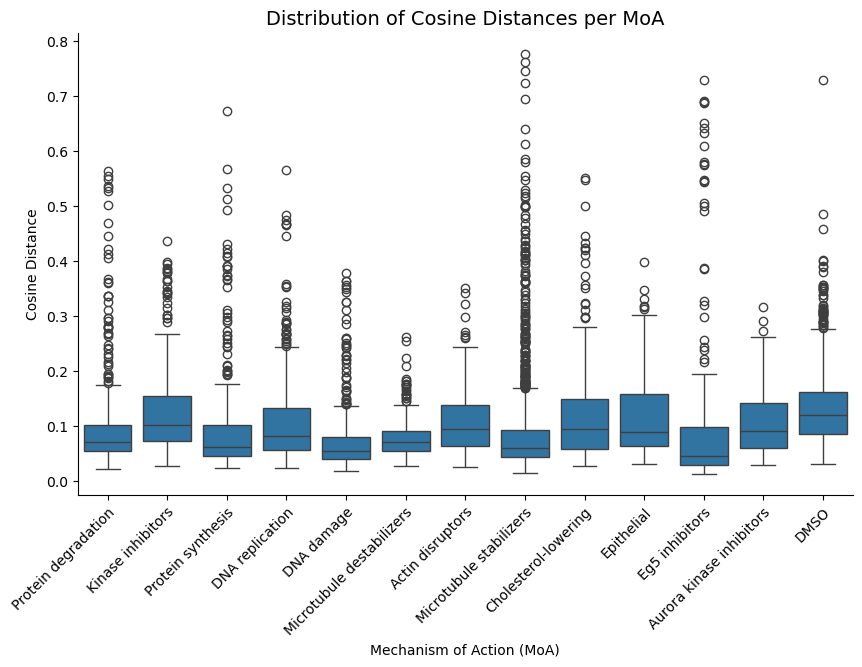

In [120]:
fig, ax = plt.subplots(figsize=(10, 6))

sns.boxplot(data=df_moa_vec_dists, x="moa", y="distance", ax=ax)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel("Mechanism of Action (MoA)")
ax.set_ylabel("Cosine Distance")
ax.set_title("Distribution of Cosine Distances per MoA", fontsize=14)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

plt.show()

In [121]:
fig.savefig(os.path.join(image_dir, "Cosine_distance_embd_vecs_moa_boxplot.png"), bbox_inches="tight")

We again have medians and interquartile ranges below 0.2. This is expected, because the embedding vectors were generated by a model trained to classify MoA. We therefore expect to get a high similarity between vectors from the same MoA. However, there is a lot of outliers. This could explain why the accuracy on the validation set was low (60% approximately). We should try removing these outliers from the dataset, and then attempt to group again per compound, in order to see if the number of outliers in the distributions obtained when comparing with mean vector per compound also decreases. Let's first have a look at the percentage of e,bedding vectors having a cosine si,ilarity superior to 90% to the mean vecotr obtained by grouping vecotrs per MoA.

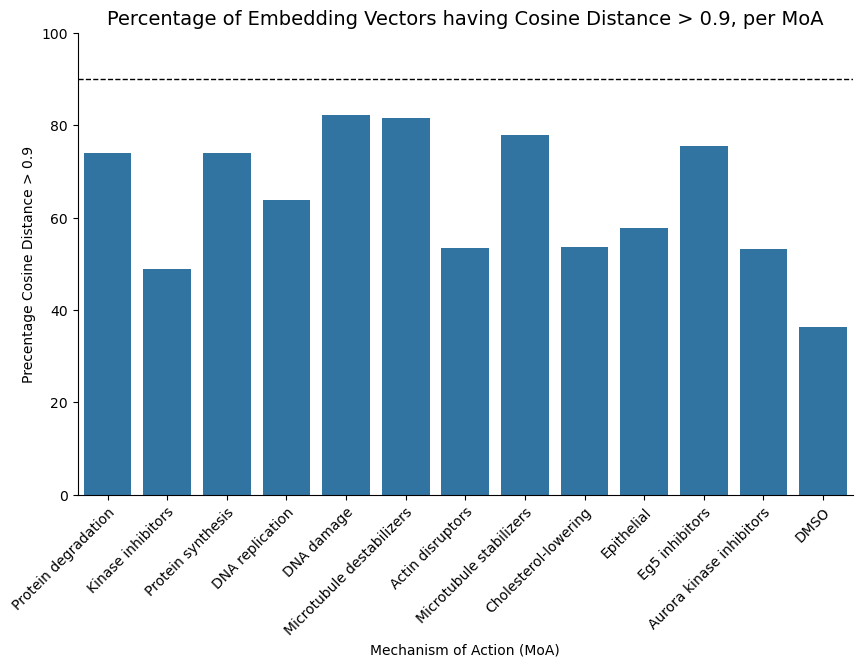

In [122]:
fig, ax = plt.subplots(figsize=(10, 6))

sns.barplot(data=df_moa_vec_stats, x="moa", y="percentage vectors > 0.9", ax=ax)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel("Mechanism of Action (MoA)")
ax.set_ylabel("Precentage Cosine Distance > 0.9")
ax.set_title("Percentage of Embedding Vectors having Cosine Distance > 0.9, per MoA", fontsize=14)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
plt.ylim(0, 100)
plt.axhline(y=90, linewidth=1, linestyle="--", color="black")

plt.show()

In [123]:
fig.savefig(os.path.join(image_dir, "Embd_vecs_moa_gt90_barplot.png"), bbox_inches="tight")

### Visualize Embedding Vectors With Outlier Removal

In [124]:
moa_dist_histos = dict()
moa_vec_stats = list()
moa_vec_dists = list()
for moa in df["Image_Metadata_MoA"].unique():
    df_moa = df[df["Image_Metadata_MoA"] == moa].copy()

    df_mean_vec = (
        df_moa.groupby(["Image_Metadata_MoA"])[vec_cols].mean().reset_index()
    )
    df_moa_data = df_moa[vec_cols].to_numpy()
    df_moa_mean = df_mean_vec[vec_cols].to_numpy()

    num_tot_vectors = df_moa.shape[0]

    # outlier remval using the IQR rule
    df_moa["distance_to_mean_vec"] = df_moa.apply(lambda r: distance.cosine(df_moa_mean[0], r[vec_cols]), axis=1)
    df_moa = remove_outliers(df_moa)

    num_corr_vectors = df_moa.shape[0]
    
    moa_dist = np.zeros((df_moa_data.shape[0]))
    for i in range(df_moa_data.shape[0]):
        moa_dist[i] = distance.cosine(df_moa_mean[0], df_moa_data[i, :])

    num_vectors_min_90 = np.extract(df_moa["distance_to_mean_vec"] < 0.1, df_moa["distance_to_mean_vec"]).shape[0]

    moa_vec_stats.append(
        (
            moa,
            num_tot_vectors,
            num_corr_vectors,
            num_vectors_min_90,
            (num_vectors_min_90 / num_corr_vectors) * 100,
        )
    )

    moa_histo = np.histogram(df_moa["distance_to_mean_vec"])
    moa_dist_histos[moa] = moa_histo
    moa_vec_dists.extend(list(zip([moa]*len(df_moa["distance_to_mean_vec"]), df_moa["distance_to_mean_vec"])))

df_moa_vec_dists = pd.DataFrame().from_records(
    data=moa_vec_dists, 
    columns=["moa", "distance"]
)
df_moa_vec_stats = pd.DataFrame.from_records(
    data=moa_vec_stats,
    columns=["moa", "total no vectors", "corrected no vectors", "corrected no vectors > 0.9", "percentage vectors > 0.9"],
)
df_moa_vec_stats.shape

(13, 5)

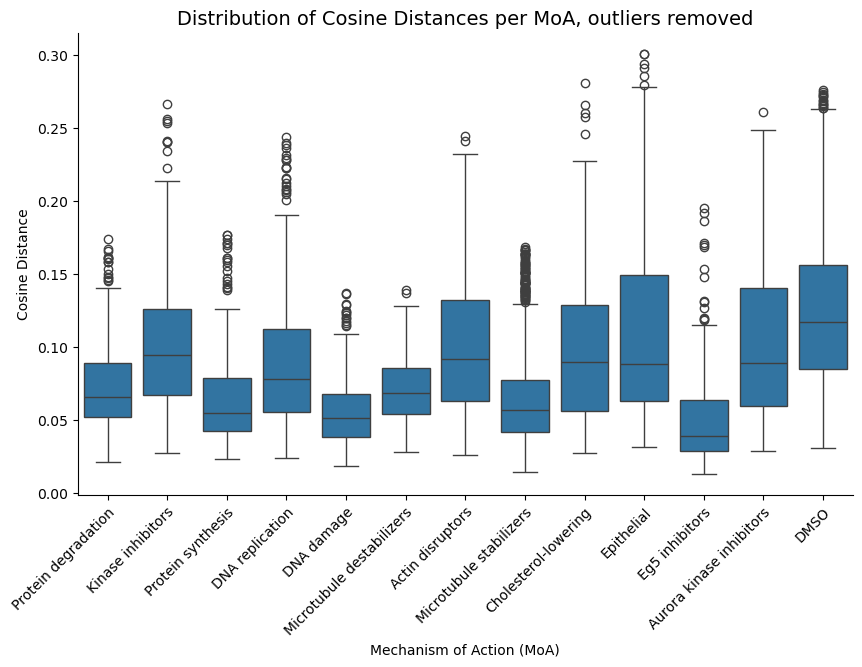

In [125]:
fig, ax = plt.subplots(figsize=(10, 6))

sns.boxplot(data=df_moa_vec_dists, x="moa", y="distance", ax=ax)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel("Mechanism of Action (MoA)")
ax.set_ylabel("Cosine Distance")
ax.set_title("Distribution of Cosine Distances per MoA, outliers removed", fontsize=14)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

plt.show()

In [126]:
fig.savefig(os.path.join(image_dir, "Cosine_distance_embd_vecs_moa_boxplot_no_outliers.png"), bbox_inches="tight")

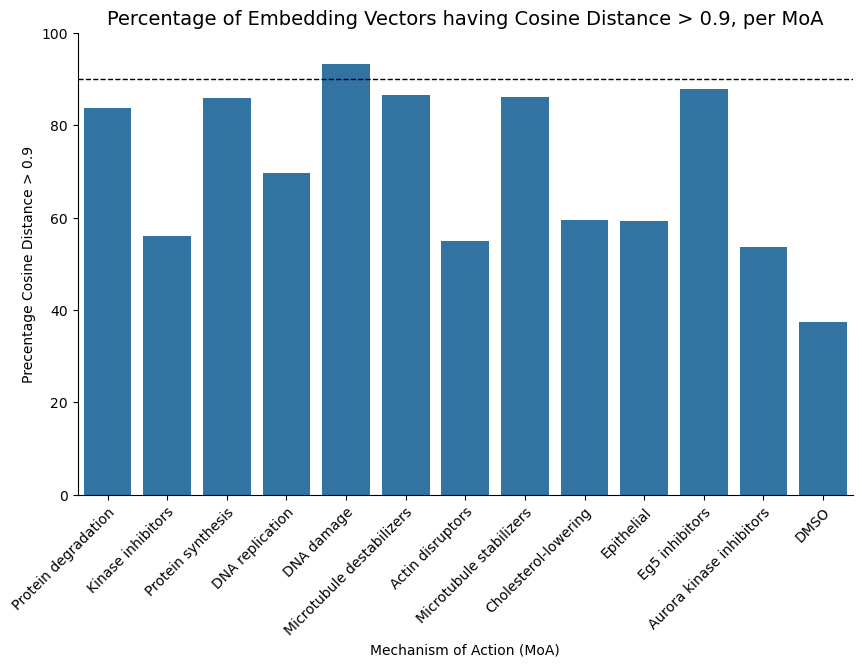

In [127]:
fig, ax = plt.subplots(figsize=(10, 6))

sns.barplot(data=df_moa_vec_stats, x="moa", y="percentage vectors > 0.9", ax=ax)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel("Mechanism of Action (MoA)")
ax.set_ylabel("Precentage Cosine Distance > 0.9")
ax.set_title("Percentage of Embedding Vectors having Cosine Distance > 0.9, per MoA", fontsize=14)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
plt.ylim(0, 100)
plt.axhline(y=90, linewidth=1, linestyle="--", color="black")

plt.show()

In [128]:
fig.savefig(os.path.join(image_dir, "Embd_vecs_moa_gt90_barplot_no_outliers.png"), bbox_inches="tight")

Again, as with the compounds we also see an improvement of the results when the outliers got removed. 

## Compounds Close To DMSO  

We want to see how many compounds are close to DMSO, the null control of the screen. To do this we calculate the Cosine distance betwween the mean vectors of the compounds and the mean vector of DMSO. We visualize the distribution using a bar plot. In this analysis we use the dataset in which the outliers have been removed.

In [129]:
df_dmso_mean = (
    df_corrected[df_corrected["Image_Metadata_Compound"] == "DMSO"]
    .groupby(["Image_Metadata_Compound"])[vec_cols]
    .mean()
    .reset_index()
)
dmso_mean_vec = df_dmso_mean[vec_cols].to_numpy()[0]

In [130]:
df_compounds = df[df["Image_Metadata_Compound"] != "DMSO"]
df_compounds.shape

(4840, 2062)

In [131]:
dmso_compound_dist = list()
for compound in df_compounds["Image_Metadata_Compound"].unique():
    df_compound = df_corrected[df_corrected["Image_Metadata_Compound"] == compound]
    df_mean_vec = (
        df_compound.groupby(["Image_Metadata_Compound"])[vec_cols].mean().reset_index()
    )
    mean_vec = df_compound[vec_cols].to_numpy()[0]

    dist_to_dmso = distance.cosine(dmso_mean_vec, mean_vec)
    dmso_compound_dist.append((compound, dist_to_dmso, 1 - dist_to_dmso))

df_dmso_compound_dist = pd.DataFrame().from_records(
    data=dmso_compound_dist,
    columns=["compound", "cosine distance", "cosine similarity"],
)
df_dmso_compound_dist.shape

(38, 3)

In [132]:
df_dmso_compound_dist

,compound,cosine distance,cosine similarity
0,ALLN,0.174811,0.825189
1,alsterpaullone,0.143270,0.856730
2,anisomycin,0.126878,0.873122
3,bryostatin,0.232279,0.767721
4,camptothecin,0.305984,0.694016
5,chlorambucil,0.158937,0.841063
6,cisplatin,0.169840,0.830160
7,colchicine,0.309417,0.690583
8,cyclohexamide,0.176764,0.823236
9,cytochalasin B,0.057818,0.942182


Creating the bar plot to visualize the distribution.

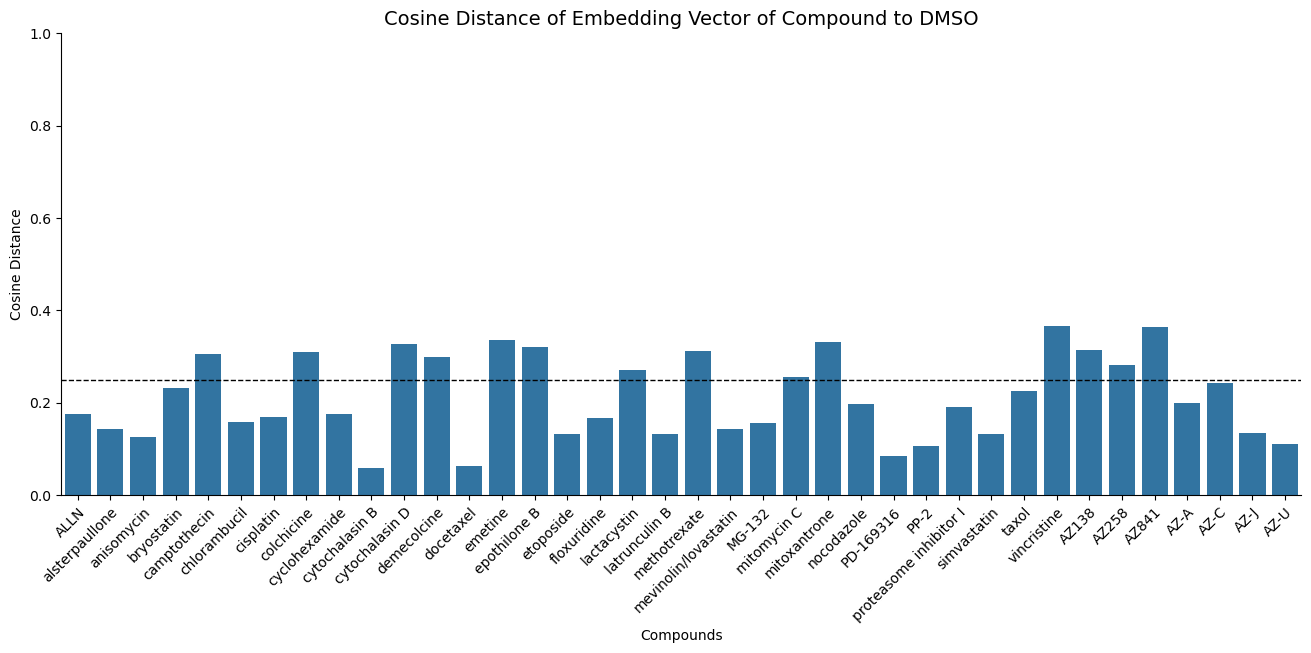

In [133]:
fig, ax = plt.subplots(figsize=(16, 6))

sns.barplot(data=df_dmso_compound_dist, x="compound", y="cosine distance", ax=ax)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel("Compounds")
ax.set_ylabel("Cosine Distance")
ax.set_title("Cosine Distance of Embedding Vector of Compound to DMSO", fontsize=14)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
plt.ylim(0, 1)
plt.axhline(y=0.25, linewidth=1, linestyle="--", color="black")

plt.show()

In [134]:
fig.savefig(os.path.join(image_dir, "Embd_vecs_dist_to_DMSO_barplot.png"), bbox_inches="tight")

## Treatment Vectors  
Before applying t-SNE and UMAP as clustering techniques we get the mean vector of the actual treatment. For 1 treatment (1 compound, 1 concentration) 4 images were taken. We now get the mean vector of the 4 images.

In [135]:
df_corrected.shape

(5783, 2063)

In [136]:
metadata_cols = df_corrected.columns[:14]
metadata_cols

Index(['TableNumber', 'ImageNumber', 'Image_FileName_DAPI',
       'Image_PathName_DAPI', 'Image_FileName_Tubulin',
       'Image_PathName_Tubulin', 'Image_FileName_Actin',
       'Image_PathName_Actin', 'Image_Metadata_Plate_DAPI',
       'Image_Metadata_Well_DAPI', 'Replicate', 'Image_Metadata_Compound',
       'Image_Metadata_Concentration', 'Image_Metadata_MoA'],
      dtype='object')

In [137]:
df_treatment_vecs = (
    df_corrected.groupby(
        [
            "Image_Metadata_Plate_DAPI",
            "Image_Metadata_Well_DAPI",
            "Replicate",
            "Image_Metadata_Compound",
            "Image_Metadata_Concentration",
            "Image_Metadata_MoA",
        ]
    )[vec_cols]
    .mean()
    .reset_index()
)

In [138]:
df_treatment_vecs.shape

(1528, 2054)

In [139]:
df_treatment_vecs.head()

,Image_Metadata_Plate_DAPI,Image_Metadata_Well_DAPI,Replicate,Image_Metadata_Compound,Image_Metadata_Concentration,Image_Metadata_MoA,V0,V1,V2,V3,...,V2038,V2039,V2040,V2041,V2042,V2043,V2044,V2045,V2046,V2047
0,Week10_40111,B02,1,DMSO,0.0,DMSO,0.329152,0.182670,0.653653,0.301282,...,0.493480,0.691962,0.673170,0.294648,0.758638,0.708489,0.149057,0.448668,0.244261,0.574436
1,Week10_40111,B11,1,taxol,0.3,Microtubule stabilizers,0.141502,0.795691,0.089647,0.390108,...,0.267071,0.156893,0.162518,0.906009,0.123000,0.218299,0.433497,0.831592,0.545760,0.068338
2,Week10_40111,C02,1,DMSO,0.0,DMSO,0.356045,0.227189,0.725408,0.142055,...,0.845039,0.580592,0.572725,0.262225,0.915239,0.783929,0.033380,0.609723,0.110013,0.521695
3,Week10_40111,C04,1,AZ138,10.0,Eg5 inhibitors,0.084999,0.210983,0.110711,0.213889,...,0.072046,0.338006,0.223531,-0.006275,0.146731,0.226570,0.397508,0.239948,0.202843,0.240747
4,Week10_40111,C05,1,AZ138,3.0,Eg5 inhibitors,0.148630,0.535516,0.067956,0.385845,...,0.291760,0.136017,0.152608,0.310605,0.115137,0.110368,0.360166,0.495632,0.465344,0.192329


## Dimensionality Reduction - Clustering  
We use the treatment dataset created with the above mentioned procedure and apply t-SNE and UMAP dimensionality reduction and clustering.

In [140]:
moas = df_treatment_vecs["Image_Metadata_MoA"].unique()
treatment_vectors = df_treatment_vecs[vec_cols]
treatment_vectors.shape

(1528, 2048)

### t-SNE Clustering

In [141]:
tsne = TSNE(perplexity=42, n_components=2, metric="cosine")
tsne_treatment_vectors = tsne.fit_transform(treatment_vectors)
print(f"t-SNE embeddings shape: {tsne_treatment_vectors.shape}")

t-SNE embeddings shape: (1528, 2)


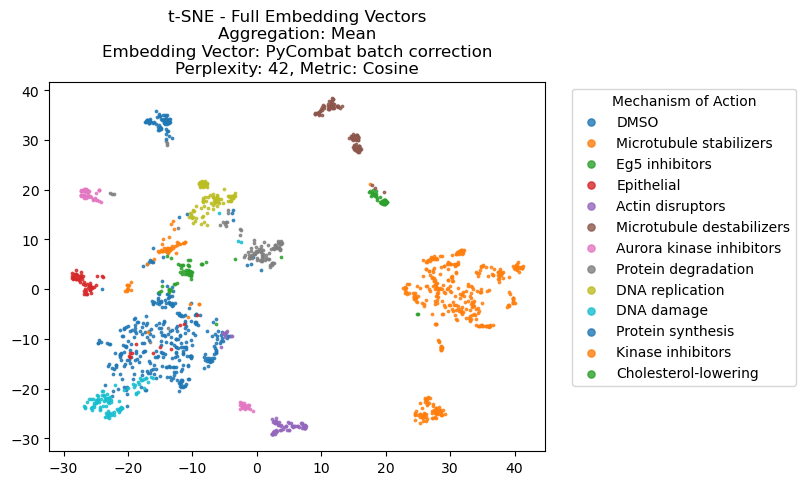

In [142]:
fig, ax = plt.subplots()

for moa in moas:
    idx = df_treatment_vecs[df_treatment_vecs["Image_Metadata_MoA"] == moa].index.values.tolist()
    ax.scatter(tsne_treatment_vectors[idx, 0], tsne_treatment_vectors[idx, 1], s=3, alpha=0.8, label=moa)
# plt.grid(True)
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left", markerscale=3, title="Mechanism of Action")
plt.title("t-SNE - Full Embedding Vectors\nAggregation: Mean\nEmbedding Vector: PyCombat batch correction\nPerplexity: 42, Metric: Cosine")
# plt.savefig(os.path.join(image_dir, "t-sne_mean.png"), bbox_inches="tight")

plt.show()

In [143]:
fig.savefig(os.path.join(image_dir, "Embd_vecs_compound_t-SNE.png"), bbox_inches="tight")

### UMAP Clustering

In [144]:
umap_mean = umap.UMAP(min_dist=0.8, n_neighbors=50, metric="cosine")
umap_treatment_vectors = umap_mean.fit_transform(treatment_vectors)
print(f"UMAP embeddings shape: {umap_treatment_vectors.shape}")

UMAP embeddings shape: (1528, 2)


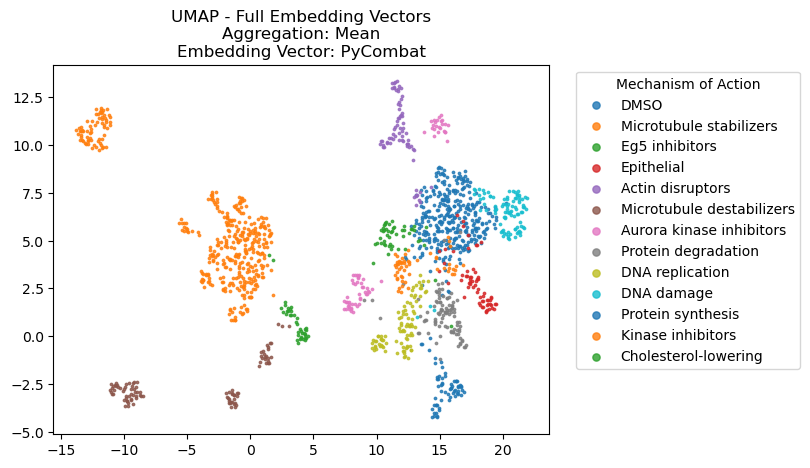

In [145]:
fig, ax = plt.subplots()

for moa in moas:
    idx = df_treatment_vecs[df_treatment_vecs["Image_Metadata_MoA"] == moa].index.values.tolist()
    ax.scatter(umap_treatment_vectors[idx, 0], umap_treatment_vectors[idx, 1], s=3, alpha=0.8, label=moa)
# plt.grid(True)
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left", markerscale=3, title="Mechanism of Action")
plt.title("UMAP - Full Embedding Vectors\nAggregation: Mean\nEmbedding Vector: PyCombat")
# plt.savefig(os.path.join(image_dir, "umap_mean.png"), bbox_inches="tight")

plt.show()

In [146]:
fig.savefig(os.path.join(image_dir, "Embd_vecs_compound_UMAP.png"), bbox_inches="tight")

The t-SNE and UMAP plots both show some similar behavior. Some of the MoAs show more consitant cluserings such Epithelial or DNA Replication. Other such as Microtubule destabilizers or Kinase inhibitors seem to have multiple sub-clusters. Multiple reasons for this behavior could exist. One could be a concentration effect. Some compounds might induce similar morphological changes independent of the conctentration. Other compounds probably show a strong dependency on concentration. Lower compound concentrations lead very few morphological changes.

## Distance Matrix Of The Embedding Vectors  
Finally we create a distance matrix similar to the ones based on molecular fingerprints and structural descriptors. We want to compare this distance matrix to ones based on pure stuctural information (fingerprints and descriptors). For the distance matrix we also use the dataset in which the outliers got removed.

In [147]:
df_compound_moa = df_treatment_vecs.groupby(["Image_Metadata_Compound", "Image_Metadata_MoA"])[vec_cols].mean().reset_index()
df_compound_moa = df_compound_moa.sort_values(["Image_Metadata_MoA", "Image_Metadata_Compound"])
df_compound_moa.shape

(39, 2050)

In [148]:
df_compound_moa.head()

,Image_Metadata_Compound,Image_Metadata_MoA,V0,V1,V2,V3,V4,V5,V6,V7,...,V2038,V2039,V2040,V2041,V2042,V2043,V2044,V2045,V2046,V2047
20,cytochalasin B,Actin disruptors,0.409627,0.407501,0.431864,0.289954,0.297678,0.371684,0.352742,0.440208,...,0.528990,0.383775,0.387407,0.348547,0.497869,0.667941,0.230737,0.354866,0.552669,0.266586
21,cytochalasin D,Actin disruptors,0.340927,0.511027,0.249576,0.432212,0.170570,0.170286,0.504425,0.267581,...,0.381562,0.508762,0.115593,0.342482,0.501421,0.880572,0.151301,0.331303,0.543962,0.150077
29,latrunculin B,Actin disruptors,0.518882,0.224677,0.429984,0.291452,0.280650,0.327055,0.389273,0.514044,...,0.661318,0.291289,0.376802,0.144440,0.456973,0.694686,0.123539,0.230027,0.552517,0.353583
1,AZ-A,Aurora kinase inhibitors,0.408155,0.105073,0.389003,0.105719,0.188379,0.261841,0.268721,0.458565,...,0.472088,0.391893,0.150473,0.053848,0.413157,0.248064,0.380544,0.294595,0.221223,0.567573
6,AZ258,Aurora kinase inhibitors,0.246073,0.182025,0.113640,0.303105,0.327593,0.099145,0.424289,0.145156,...,0.042587,0.785901,0.144270,0.109012,0.257196,0.252284,0.784735,0.192922,0.235797,0.519821


In [149]:
compounds = df_compound_moa["Image_Metadata_Compound"].to_numpy()
embed_vectors = df_compound_moa[vec_cols].to_numpy()
moas = df_compound_moa["Image_Metadata_MoA"].unique()

In [150]:
embed_vectors.shape

(39, 2048)

In [151]:
def create_embed_vec_dist_matix(embed_vectors):
    dist_matrix = np.zeros((len(embed_vectors), len(embed_vectors)))

    for i in range(len(embed_vectors)):
        for j in range(len(embed_vectors)):
            dist_matrix[i][j] = distance.cosine(embed_vectors[i], embed_vectors[j])
    return dist_matrix

In [152]:
distance_matrix = create_embed_vec_dist_matix(embed_vectors)
similarity_matrix = 1 - distance_matrix

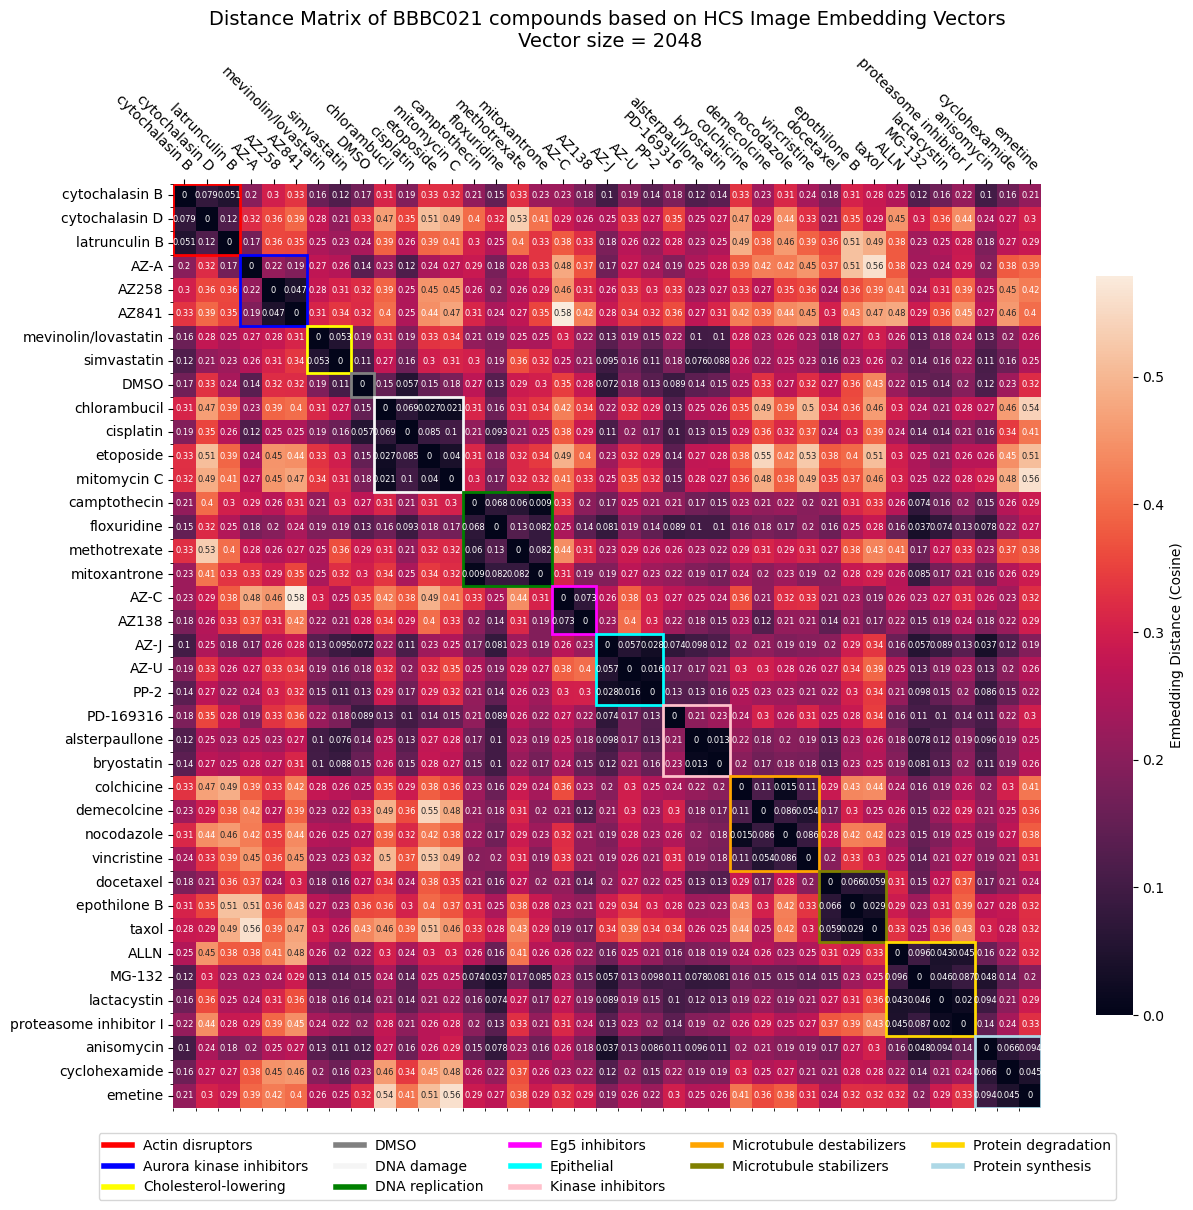

In [153]:
plot_title = "Distance Matrix of BBBC021 compounds based on HCS Image Embedding Vectors\n Vector size = 2048"

fig, ax = plt.subplots(figsize=(14,12))

sns.heatmap(distance_matrix, 
            annot=True, 
            annot_kws={"fontsize":6, "ha": "center"}, 
            fmt=".2g", 
            cbar_kws={"label": "Embedding Distance (Cosine)", "shrink": 0.8},
            ax=ax)
ax.set_yticks(range(len(compounds)), minor=True)
ax.set_yticklabels(compounds)
ax.set_xticks(range(len(compounds)), minor=True)
ax.set_xticklabels(compounds)
ax.tick_params(top=True, bottom=False, labeltop=True, labelbottom=False)
ax.set_title(plot_title, fontsize=14)

ax.add_patch(patches.Rectangle((0, 0), 3.0, 3.0, edgecolor="red", lw=2, fill=False))
ax.add_patch(patches.Rectangle((3, 3), 3.0, 3.0, edgecolor="blue", lw=2, fill=False))
ax.add_patch(patches.Rectangle((6, 6), 2.0, 2.0, edgecolor="yellow", lw=2, fill=False))
ax.add_patch(patches.Rectangle((8, 8), 1.0, 1.0, edgecolor="grey", lw=2, fill=False))
ax.add_patch(patches.Rectangle((9, 9), 4.0, 4.0, edgecolor="whitesmoke", lw=2, fill=False))
ax.add_patch(patches.Rectangle((13, 13), 4.0, 4.0, edgecolor="green", lw=2, fill=False))
ax.add_patch(patches.Rectangle((17, 17), 2.0, 2.0, edgecolor="magenta", lw=2, fill=False))
ax.add_patch(patches.Rectangle((19, 19), 3.0, 3.0, edgecolor="cyan", lw=2, fill=False))
ax.add_patch(patches.Rectangle((22, 22), 3.0, 3.0, edgecolor="pink", lw=2, fill=False))
ax.add_patch(patches.Rectangle((25, 25), 4.0, 4.0, edgecolor="orange", lw=2, fill=False))
ax.add_patch(patches.Rectangle((29, 29), 3.0, 3.0, edgecolor="olive", lw=2, fill=False))
ax.add_patch(patches.Rectangle((32, 32), 4.0, 4.0, edgecolor="gold", lw=2, fill=False))
ax.add_patch(patches.Rectangle((36, 36), 3.0, 3.0, edgecolor="lightblue", lw=2, fill=False))

custom_legend = [Line2D([0], [0], color="red", lw=4),
                Line2D([0], [0], color="blue", lw=4),
                Line2D([0], [0], color="yellow", lw=4),
                Line2D([0], [0], color="grey", lw=4),
                Line2D([0], [0], color="whitesmoke", lw=4),
                Line2D([0], [0], color="green", lw=4),
                Line2D([0], [0], color="magenta", lw=4),
                Line2D([0], [0], color="cyan", lw=4),
                Line2D([0], [0], color="pink", lw=4),
                Line2D([0], [0], color="orange", lw=4),
                Line2D([0], [0], color="olive", lw=4),
                Line2D([0], [0], color="gold", lw=4),
                Line2D([0], [0], color="lightblue", lw=4)]

ax.legend(custom_legend, moas, loc='upper center', bbox_to_anchor=(0.5, -0.02), fancybox=True, shadow=False, ncol=5)

plt.setp(ax.get_xticklabels(), rotation=-45, ha="right", rotation_mode="anchor")
plt.setp(ax.get_yticklabels(), rotation=0, ha="right", rotation_mode="anchor")

plt.show()

In [154]:
fig.savefig(os.path.join(image_dir, "Embd_vecs_distance_matrix_compounds.png"), bbox_inches="tight")